Nama  : Muhammad Zhafran Ghaly

ID    : m183x0348


Kelas : M02


Divisi: Machine Learning and Front-End

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = pd.read_csv('BTC-USD.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,404.424988,21460800


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.shape

(2713, 7)

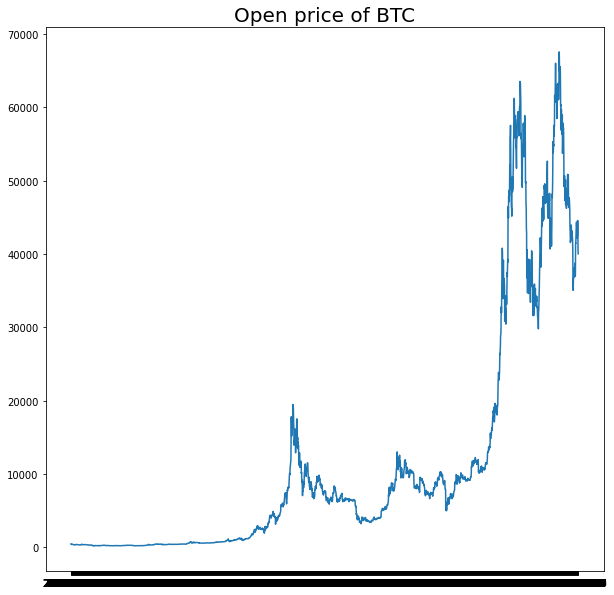

In [8]:
date = df['Date'].values
open = df['Open'].values
plt.figure(figsize = (10,10))
plt.plot(date, open)
plt.title('Open price of BTC',
          fontsize = 20);

In [9]:
cols = [0,1]
df = df[df.columns[cols]]
df

,Date,Open
0,2014-09-17,465.864014
1,2014-09-18,456.859985
2,2014-09-19,424.102997
3,2014-09-20,394.673004
4,2014-09-21,408.084991
...,...,...
2708,2022-02-15,42586.464844
2709,2022-02-16,44578.277344
2710,2022-02-17,43937.070313
2711,2022-02-18,40552.132813


In [48]:
open = open.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_open = scaler.fit_transform(open)
scaled_open = scaled_open.reshape(1, -1)
scaled_open = np.hstack(scaled_open)
scaled_open

array([0.00428907, 0.00415543, 0.00366922, ..., 0.64952249, 0.59928062,
       0.59141395])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
                                    date,
                                    scaled_open, 
                                    test_size=0.2, 
                                    random_state=1, 
                                    shuffle=False)

print(len(X_train), len(X_test))

2170 543


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [37]:
training_set = windowed_dataset(y_train, window_size = 64, 
                             batch_size = 200, 
                             shuffle_buffer = 1000)
validation_set = windowed_dataset(y_test, window_size=64,
                           batch_size=200,
                           shuffle_buffer=1000)

model = tf.keras.Sequential([
   
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=['accuracy'])

In [16]:
gauge = (max(scaled_open) - min(scaled_open)) * 0.1
print(gauge)

0.1


In [25]:
class Callbackhx(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < gauge) and (logs.get('val_mae') < gauge):
      self.model.stop_training = True
      print('\nFor Epoch', epoch, ' training has been stopped.''\n Because MAE of the model has reach < 10% of data scale')
callbacks = Callbackhx()

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 1.0000e-04, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])


In [42]:
history = model.fit(
    training_set,
    epochs = 100, 
    validation_data = validation_set,
    callbacks = [callbacks]
)

Epoch 1/100
11/11 [==============================] - 3s 281ms/step - loss: 5.4635e-04 - mae: 0.0286 - val_loss: 0.0646 - val_mae: 0.3362
Epoch 2/100
11/11 [==============================] - 3s 242ms/step - loss: 5.4604e-04 - mae: 0.0286 - val_loss: 0.0646 - val_mae: 0.3362
Epoch 3/100
11/11 [==============================] - 3s 245ms/step - loss: 5.4582e-04 - mae: 0.0286 - val_loss: 0.0645 - val_mae: 0.3361
Epoch 4/100
11/11 [==============================] - 3s 241ms/step - loss: 5.4556e-04 - mae: 0.0286 - val_loss: 0.0645 - val_mae: 0.3361
Epoch 5/100
11/11 [==============================] - 3s 242ms/step - loss: 5.4524e-04 - mae: 0.0285 - val_loss: 0.0645 - val_mae: 0.3360
Epoch 6/100
11/11 [==============================] - 3s 244ms/step - loss: 5.4495e-04 - mae: 0.0285 - val_loss: 0.0645 - val_mae: 0.3360
Epoch 7/100
11/11 [==============================] - 3s 242ms/step - loss: 5.4469e-04 - mae: 0.0285 - val_loss: 0.0645 - val_mae: 0.3359
Epoch 8/100
11/11 [======================

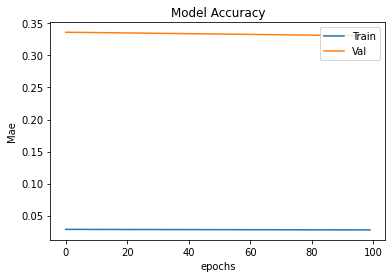

In [43]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mae')
plt.xlabel('epochs')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

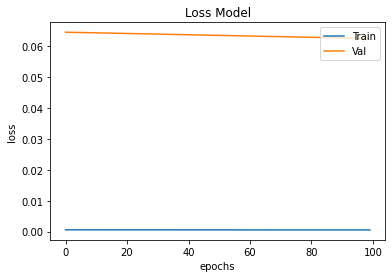

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()